In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from convokit import Corpus, download
import random
import os
import re
import unicodedata
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import itertools
import math
import time

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data loading and preprocessing
corpus = Corpus(filename=download("movie-corpus"))

In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
# Extract sentence pairs
all_pairs = []
for conv in corpus.get_conversation_ids():
    conversation = corpus.get_conversation(conv)
    utterance_ids = conversation.get_utterance_ids()
    for i in range(len(utterance_ids) - 1):
        utt1 = corpus.get_utterance(utterance_ids[i])
        utt2 = corpus.get_utterance(utterance_ids[i + 1])
        if utt1 and utt2:  # Ensure both utterances are not None
            all_pairs.append([normalize_string(utt2.text), normalize_string(utt1.text)])


In [6]:
# Flatten the list and filter out too long sentences
all_pairs = [
    pair
    for pair in all_pairs
    if 2 <= len(pair[0].split(" ")) <= 10 and 2 <= len(pair[1].split(" ")) <= 10
]

In [7]:
all_pairs[:10000]

[['they do to !', 'they do not !'],
 ['she okay ?', 'i hope so .'],
 ['the real you .', 'like my fear of wearing pastels ?'],
 ['what good stuff ?', 'the real you .'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['well no . . .', 'then that s all you had to say .'],
 ['you know chastity ?', 'i believe we share an art instructor'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['there .', 'where ?'],
 ['that s because it s such a nice one .', 'forget french .'],
 ['i have to be home in twenty minutes .',
  'i don t have to be home til two .'],
 ['who ?', 'joey .'],
 ['where did he go ? he was just here .', 'who ?'],
 ['no .', 'you might wanna think about it'],
 ['did you change your hair ?', 'no .'],
 ['hey sweet cheeks .', 'hi joey .'],
 ['it s more', 'expensive ?'],
 ['patrick is that a .', 'perm ?'],
 ['you set me up .', 'i just wanted '],
 ['let go !', 'you set me up .'],
 ['you looked beautiful last night 

In [114]:
# Reduce dataset size
sample_pairs = random.sample(all_pairs, int(len(all_pairs) * 0.2))
train_pairs, val_pairs = train_test_split(sample_pairs, test_size=0.2)

In [115]:
len(train_pairs), len(val_pairs)

(11872, 2969)

In [63]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

In [64]:
# Vocabulary class
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count default tokens

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

In [116]:
voc = Voc('movie-corpus')

In [117]:
for pair in train_pairs:
    voc.add_sentence(pair[0])
    voc.add_sentence(pair[1])

In [118]:
voc.num_words

8409

In [119]:
filtered_val_pairs = []

# Iterate through val_pairs
for pair in val_pairs:

    # Split each sentence into words
    words_0 = pair[0].split()
    words_1 = pair[1].split()
    
    # Check if all words in both sentences are in the vocabulary
    if all(word in voc.word2index for word in words_0) and all(word in voc.word2index for word in words_1):
        
        # If all words are in the vocabulary, append the pair to the filtered list
        filtered_val_pairs.append(pair)

In [120]:
len(val_pairs), len(filtered_val_pairs)

(2969, 2087)

In [121]:
val_pairs = filtered_val_pairs

In [14]:
# Prepare data for training
def indexes_from_sentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zero_padding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [16]:
def binary_matrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


In [17]:
def input_var(l, voc):
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    pad_var = torch.LongTensor(pad_list)
    return pad_var, lengths

In [18]:
def output_var(l, voc):
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    mask = binary_matrix(pad_list)
    mask = torch.BoolTensor(mask)
    pad_var = torch.LongTensor(pad_list)
    return pad_var, mask, max_target_len

In [19]:
def batch2train_data(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = input_var(input_batch, voc)
    output, mask, max_target_len = output_var(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [21]:
# Model building
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        embedded = self.embedding(input_seq)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        return outputs, hidden

In [22]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [23]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

In [32]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss.to(device)
    return loss, nTotal.item()


In [33]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()

    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [84]:
def validate(encoder, decoder, voc, validation_data, batch_size):
    # Set the encoder and decoder model to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        validation_loss = 0
        n_totals = 0

        # Create batches for the validation data
        validation_batches = [batch2train_data(voc, [random.choice(validation_data) for _ in range(batch_size)])
                              for _ in range(len(validation_data) // batch_size)]

        for validation_batch in validation_batches:
            input_variable, lengths, target_variable, mask, max_target_len = validation_batch

            input_variable = input_variable.to(device)
            lengths = lengths.to(device)
            target_variable = target_variable.to(device)
            mask = mask.to(device)

            # Forward pass through the encoder
            encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

            # Create initial decoder input (start with SOS tokens for each sentence)
            decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
            decoder_input = decoder_input.to(device)

            # Set initial decoder hidden state to the encoder's final hidden state
            decoder_hidden = encoder_hidden[:decoder.n_layers]

            # Forward batch of sequences through decoder one time step at a time
            for t in range(max_target_len):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                # No teacher forcing: next input is decoder's own current output
                _, topi = decoder_output.topk(1)
                decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
                decoder_input = decoder_input.to(device)

                # Calculate and accumulate loss
                mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
                validation_loss += mask_loss.item() * nTotal
                n_totals += nTotal

        # Compute the average loss and perplexity over the validation set
        validation_loss_avg = validation_loss / n_totals
        perplexity = np.exp(validation_loss_avg)

    # Set the models back to training mode
    encoder.train()
    decoder.train()

    return validation_loss_avg, perplexity


In [91]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

def train_iters(voc, train_pairs, val_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, n_iteration, batch_size, print_every, save_every, clip, validate_every):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    plot_losses = []
    plot_val_losses = []
    plot_perplexities = []
    plot_val_perplexities = []

    training_batches = [batch2train_data(voc, [random.choice(train_pairs) for _ in range(batch_size)]) for _ in range(n_iteration)]
    
    for iteration in range(1, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch
        
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss_total += loss
        
        if iteration % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iteration / n_iteration), iteration, iteration / n_iteration * 100, print_loss_avg))
            plot_losses.append(print_loss_avg)
            plot_perplexities.append(np.exp(print_loss_avg))
        
        if iteration % validate_every == 0:
            val_loss, val_perplexity = validate(encoder, decoder, voc, val_pairs, batch_size)
            # Append validation loss and calculate perplexity
            plot_val_losses.append(val_loss)
            plot_val_perplexities.append(val_perplexity)
        
        if iteration % save_every == 0:
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join("checkpoints", '{}_{}.tar'.format(iteration, 'checkpoint')))

    # Plotting training and validation losses and perplexities
    print(plot_perplexities)
    print(plot_val_perplexities)
    plt.figure()
    plt.plot(plot_losses, label='Training Loss')
    plt.plot(plot_val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(plot_perplexities, label='Training Perplexity')
    plt.plot(plot_val_perplexities, label='Validation Perplexity')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()



In [102]:
# Model hyperparameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
decoder_learning_ratio = 5.0
clip = 50.0
learning_rate = 0.0001
n_iteration = 50
print_every = 1
save_every = 5
validate_every = 1

In [123]:
voc.word2coun['i']

11

In [103]:
# Initialize encoder and decoder models
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, 
                     embedding, 
                     encoder_n_layers, 
                     dropout)

decoder = LuongAttnDecoderRNN('dot', 
                               embedding, 
                               hidden_size, 
                               voc.num_words,
                               decoder_n_layers, 
                               dropout)t

In [104]:
# Initialize optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

0m 0s (- 0m 38s) (1 2%) 8.1985
0m 2s (- 0m 48s) (2 4%) 8.1300
0m 3s (- 0m 48s) (3 6%) 7.8842
0m 4s (- 0m 47s) (4 8%) 7.3679
0m 5s (- 0m 45s) (5 10%) 7.1385
0m 6s (- 0m 48s) (6 12%) 6.3136
0m 7s (- 0m 46s) (7 14%) 6.1941
0m 8s (- 0m 45s) (8 16%) 5.8544
0m 9s (- 0m 43s) (9 18%) 7.0304
0m 10s (- 0m 42s) (10 20%) 7.2123
0m 12s (- 0m 42s) (11 22%) 5.9627
0m 13s (- 0m 41s) (12 24%) 6.5634
0m 14s (- 0m 39s) (13 26%) 5.2865
0m 14s (- 0m 38s) (14 28%) 5.6457
0m 15s (- 0m 37s) (15 30%) 5.1610
0m 17s (- 0m 37s) (16 32%) 4.9911
0m 18s (- 0m 36s) (17 34%) 4.7073
0m 19s (- 0m 35s) (18 36%) 4.6881
0m 20s (- 0m 33s) (19 38%) 4.9681
0m 21s (- 0m 32s) (20 40%) 4.6519
0m 23s (- 0m 32s) (21 42%) 4.5167
0m 24s (- 0m 31s) (22 44%) 4.5827
0m 25s (- 0m 30s) (23 46%) 4.9275
0m 26s (- 0m 29s) (24 48%) 4.6859
0m 27s (- 0m 27s) (25 50%) 4.5078
0m 30s (- 0m 27s) (26 52%) 4.7354
0m 31s (- 0m 26s) (27 54%) 4.5875
0m 32s (- 0m 25s) (28 56%) 4.7636
0m 33s (- 0m 24s) (29 57%) 4.2140
0m 34s (- 0m 22s) (30 60%) 4.3599
0m

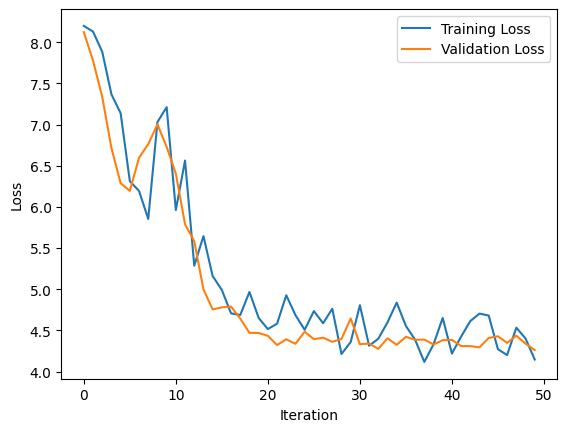

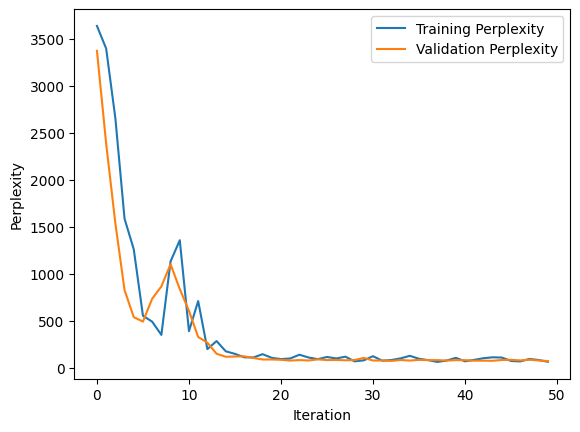

In [105]:
# Train model
train_iters(
    voc=voc,
    train_pairs=train_pairs,
    val_pairs=val_pairs,
    encoder=encoder,
    decoder=decoder,
    encoder_optimizer=encoder_optimizer,
    decoder_optimizer=decoder_optimizer,
    embedding=embedding,
    n_iteration=n_iteration,
    batch_size=batch_size,
    print_every=print_every,
    save_every=save_every,
    clip=clip,
    validate_every=validate_every
)

In [111]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
            decoder_hidden = encoder_hidden[:decoder.n_layers]

            decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
            all_tokens = torch.zeros([0], device=device, dtype=torch.long)
            all_scores = torch.zeros([0], device=device)

            for _ in range(max_length):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
                all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
                all_scores = torch.cat((all_scores, decoder_scores), dim=0)
                decoder_input = torch.unsqueeze(decoder_input, 0)
            
            return all_tokens, all_scores



In [107]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=10):
    indexes_batch = [indexes_from_sentence(voc, sentence)]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch]).to(device)
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1).to(device)
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


In [108]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while True:
        try:
            input_sentence = input('> ')
            if input_sentence in ('q', 'quit'): break
            input_sentence = normalize_string(input_sentence)
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            output_words = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))
        except KeyError:
            print("Error: Encountered unknown word.")



In [112]:
# If loading on same machine the model was trained on
checkpoint = torch.load('checkpoints/50_checkpoint.tar')

encoder_sd = checkpoint['en']
decoder_sd = checkpoint['de']
encoder_optimizer_sd = checkpoint['en_opt']
decoder_optimizer_sd = checkpoint['de_opt']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')


# Initialize word embeddings


embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models

encoder.load_state_dict(encoder_sd)
decoder.load_state_dict(decoder_sd)

# Use appropriate device

print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [113]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting 
evaluateInput(encoder, decoder, searcher, voc)

Bot: . . . .
